In [1]:
# the preprocessed data is in entity label format, However, our models are expecting the labelled dataset in BIO tagging format. 
# therefore we still need to covert the entity label format to BIO tags.
import pandas as pd
import ast
import matplotlib.pyplot as plt

In [3]:
# below is an example of entity label format
path_toData = r'‪C:\Users\spenc\OneDrive - The University of Auckland\Study\UoA\Project\matching_new.csv'
data = pd.read_csv(path_toData.strip("‪u202a"),header=0)
data.head(n=5)

,text,entities
0,"GOURMET BURGER KITCHEN, 45 GREENWICH CHURCH, S...","{'entities': [(275, 283, 'DATE'), (269, 274, '..."
1,"SUNCORP, BANK, QUICK EASY CONUENIEN, BRISBANE ...","{'entities': [(319, 329, 'DATE'), (330, 335, ..."
2,"C ABCHARGE H, TAX INVOICE, SILVERTOP VIC 13100...","{'entities': [(258, 266, 'DATE'), (201, 207, '..."
3,"NZ DRYCLEANERS, 14 POLYGON ROAD, ST HELIERS, *...","{'entities': [(90, 95, 'TIME'), (189, 198, 'AM..."
4,"HMSHOST NZ LIMITED, AUCKLAND INT AIRPORT, (09)...","{'entities': [(96, 101, 'TIME'), (199, 208, 'A..."


In [2]:
#covert all text to lower case to reduce computational complexity
seriesLower = data['text'].apply(lambda x: x.lower())
entities = data['entities'].apply(lambda x: ast.literal_eval(x))
dataLower = seriesLower.to_frame().join(entities)
dataLower.head(n=5)

NameError: name 'data' is not defined

In [19]:
dataLower.text.map(len).max()

9353

In [ ]:
#we convert the invoice text to lowercases to reduce the computation complexity
import spacy 
sp = spacy.load('en_core_web_lg')
dataToken = dataLower['text'].apply(lambda x: sp(x))

In [ ]:
# we only keep invoice that contain no more than 500 tokens. 
# we found that there are a couple of invoice is extremely long (more than 1000 tokens)
# the majority of them has a maximum of 497 tokens. 
# because LTSM networks have a fixed sequence size, if we pad all sequence to 1000 tokens, it will be extremely expensive to train
# therefore we set the limit to 500 tokens, 
dataEntities = dataToken.to_frame().join(dataLower['entities'])
dataEntities.head(n=5)
dataEntities = dataEntities[-dataEntities['text'].apply(lambda x: len(x) > 500)] # only keep 500 token

In [6]:
# a function used to append BIO tags to the entity labels
def entitySetter(_token, _inputDataSeries):
    if len(_inputDataSeries['entities']) > 1:
        for entity in _inputDataSeries['entities']:
            if _token.idx >= int(entity[0]) and _token.idx < int(entity[1]):
                if _token.idx == int(entity[0]):
                    _token.ent_type_ = "B-" + entity[2]
                else:
                    _token.ent_type_ = "I-" + entity[2]
                break
            else:
                    _token.ent_type_ = 'O'
    else:
        _token.ent_type_ = 'O'
    return _token

In [ ]:
dataEntities.iloc[0]
len(dataEntities.index)

In [ ]:
i = 0
while i < len(dataEntities.index):
    for token in dataEntities.iloc[i]['text']:
        token = entitySetter(token, dataEntities.iloc[i]['entities'])
    i = i + 1

In [ ]:
rows = []

In [ ]:
i = 0
while i < len(dataEntities.index):
    j = 0
    while j < len(dataEntities.iloc[i]['text']):
        rows.append(['invoice_' + str(i + 1), dataEntities.iloc[i]['text'][j].text, dataEntities.iloc[i]['text'][j].pos_, dataEntities.iloc[i]['text'][j].ent_type_])
        j = j+1
    i = i +1

In [ ]:
preproccessDf = pd.DataFrame(rows, columns = ['invoice_id', 'token', 'POS', 'tag'])

In [84]:
# an example of BIO taggs. 
preproccessDf['tag'].unique()

array(['B-MERCHANT', 'I-MERCHANT', 'O', 'B-TIME', 'B-DATE', 'I-DATE',
       'B-AMOUNT', 'I-AMOUNT', 'I-TIME', 'B-GST', 'I-GST'], dtype=object)

In [ ]:
preproccessDf.to_csv('BIO_tagged_data.csv', index = False)

In [2]:
# a sample of BIO tagged data
BIO_tagged_data = pd.read_csv('BIO_tagged_data.csv', header = 0)
BIO_tagged_data = BIO_tagged_data.drop(['POS'], axis =1)
BIO_tagged_data.head(n=5)

,invoice_id,token,tag
0,invoice_1,gourmet,B-MERCHANT
1,invoice_1,burger,I-MERCHANT
2,invoice_1,kitchen,I-MERCHANT
3,invoice_1,",",O
4,invoice_1,45,O


In [3]:
# sentence getter is a function I found from the Internet which produces the entity token and entity label pair (in python tuple), example can be seen later.
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["token"].values.tolist(),s["tag"].values.tolist())]
        self.grouped = self.data.groupby("invoice_id").apply(agg_func)
        self.invoices = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["invoice_{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [4]:
tags = list(set(BIO_tagged_data["tag"].values))
n_tags = len(tags)
n_tags

11

In [5]:
tokens = set(list(BIO_tagged_data['token'].values))
tokens.add('PADtoken')
n_tokens = len(tokens)
n_tokens

28569

In [6]:
# entity token and entity label pair
getter = SentenceGetter(BIO_tagged_data)
sent = getter.get_next()
print(sent)

[('gourmet', 'B-MERCHANT'), ('burger', 'I-MERCHANT'), ('kitchen', 'I-MERCHANT'), (',', 'O'), ('45', 'O'), ('greenwich', 'O'), ('church', 'O'), (',', 'O'), ('st', 'O'), (',', 'O'), ('london', 'O'), (',', 'O'), ('m*07469', 'O'), (',', 'O'), ('tid', 'O'), (',', 'O'), ('tid*1', 'O'), ('*', 'O'), ('9345', 'O'), (',', 'O'), ('9345', 'O'), (',', 'O'), ('aid', 'O'), ('a0000000031010', 'O'), (',', 'O'), ('visa', 'O'), (',', 'O'), ('visa', 'O'), (',', 'O'), ('e', 'O'), ('30', 'O'), ('3', 'O'), (',', 'O'), ('6162', 'O'), (',', 'O'), ('icc', 'O'), (',', 'O'), ('pan.seq', 'O'), ('01', 'O'), (',', 'O'), ('sale', 'O'), (',', 'O'), ('cardholder', 'O'), ('copy', 'O'), (',', 'O'), ('please', 'O'), ('keep', 'O'), ('this', 'O'), ('receipt', 'O'), (',', 'O'), ('for', 'O'), ('your', 'O'), ('records', 'O'), (',', 'O'), ('amount', 'O'), (',', 'O'), ('e17.75', 'O'), (',', 'O'), ('verified', 'O'), ('by', 'O'), ('signature', 'O'), (',', 'O'), ('thank', 'O'), ('you', 'O'), (',', 'O'), ('14:28', 'B-TIME'), ('22/11

In [7]:
invoices = getter.invoices
print(len(invoices))
longest_inv = max(len(invoice) for invoice in invoices)
print('longest invoices has {} tokens'.format(longest_inv))

1281
longest invoices has 496 tokens


In [8]:
# in our training data, the longest invoice contains 496 tokens, (during the preprocess, we only kept invoice that has less than 500 tokens)
# for invoices that shorther than 497 tokens long, we pad it with padtokens. 
max_len = 496
X = [[w[0]for w in s] for s in invoices]
print(X[1])
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADtoken")
    new_X.append(new_seq)
print('------------------------------------------------------------------------------------------')
print(new_X[1])

['vietnamese', 'restaurant', ',', 'london', ',', '<', ',', 'm', ':', '59091', ',', 'tid', '2995', ',', '$', '29227', ',', 'sch', 'id:004325562650079', ',', 'handset', ':', '1', ',', 'visa', 'credit', ',', 'aid', ':', 'a0000000031010', ',', 'visa', ',', '0565', ',', 'pan', 'seq', 'no', '.', '01', ',', 'icc', ',', 'sale', ',', 'amount', ',', '32.30', ',', 'total', ',', '232.30', ',', 'signature', 'verified', ',', 'thank', 'you', ',', '21/11/14', '14:35', ',', 'auth', 'code:865270', ',', 'txn', '7723', ',', 'customer', 'copy', ',', 'please', 'retain', 'receipt']
------------------------------------------------------------------------------------------
['vietnamese', 'restaurant', ',', 'london', ',', '<', ',', 'm', ':', '59091', ',', 'tid', '2995', ',', '$', '29227', ',', 'sch', 'id:004325562650079', ',', 'handset', ':', '1', ',', 'visa', 'credit', ',', 'aid', ':', 'a0000000031010', ',', 'visa', ',', '0565', ',', 'pan', 'seq', 'no', '.', '01', ',', 'icc', ',', 'sale', ',', 'amount', ',', '

In [9]:
from keras.preprocessing.sequence import pad_sequences
tags2index = {t:i+1 for i,t in enumerate(tags)}
# instead of using the real token, we map token to indices, for example 1 for merchant, 2 for GST
y = [[tags2index[w[1]] for w in s] for s in invoices]
# the padding tokens are mapped to 0
tags2index["PADtoken"] = 0 #annotation

Using TensorFlow backend.


In [10]:
# after pad all invoice, the data is now 1291 invoice of 496 tokens each
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["PADtoken"])
print(y.shape)

(1281, 496)


In [11]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.python.keras import backend as K
# few tensorflow configuration, allow gpu consumption to grow
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# train and test data to split
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2020)
# load the elmo model module using tensoflow hub
elmo_model = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
#elmo_model = hub.load('./elmo_3')

In [12]:
type(X_te)

list

In [13]:
print(len(X_te))

129


In [14]:
tags2index

{'B-MERCHANT': 1,
 'B-AMOUNT': 2,
 'I-TIME': 3,
 'O': 4,
 'I-DATE': 5,
 'I-MERCHANT': 6,
 'I-GST': 7,
 'B-GST': 8,
 'I-AMOUNT': 9,
 'B-TIME': 10,
 'B-DATE': 11,
 'PADtoken': 0}

In [15]:
# elmo embedding function, this function is outlined here: https://towardsdatascience.com/elmo-helps-to-further-improve-your-word-embeddings-c6ed2c9df95f
def ElmoEmbedding(x):
    return elmo_model(inputs={"tokens": tf.squeeze(tf.cast(x,tf.string)),"sequence_len": tf.constant(batch_size*[max_len])
                     },
                      signature="tokens",
                      as_dict=True)["elmo"]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 496)          0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 496, 1024)    0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 496, 1024)    6295552     lambda_1[0][0]                   
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 496, 1024)    6295552     bidirectional_1[0][0]            
____________________________________________________________________________________________

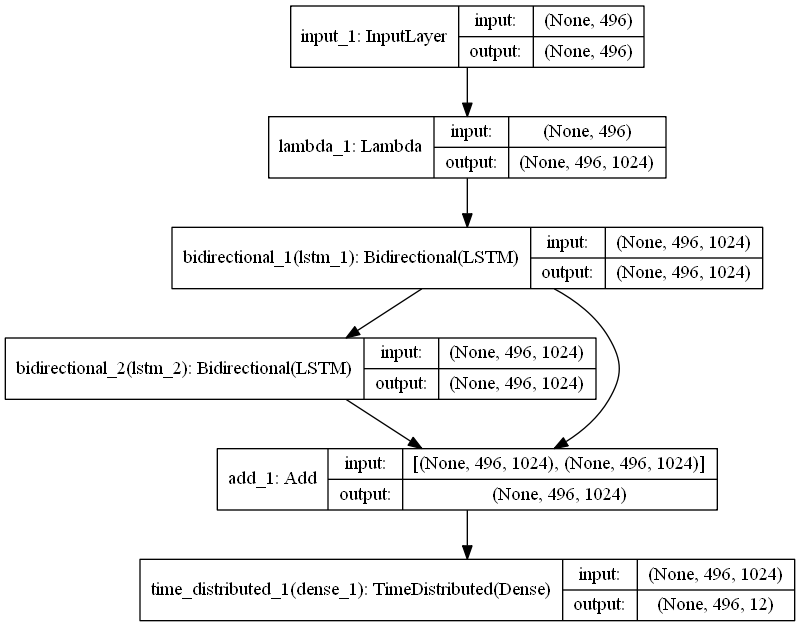

In [16]:
from keras.models import Model, Input, model_from_yaml, load_model
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
# from keras_contrib.layers import CRF
# from keras_contrib.losses import crf_loss
# from keras_contrib.metrics import crf_accuracy

# the construction of the elmo model
batch_size = 8
input_text = Input(shape=(max_len,), dtype='string')#tf.string
input_text = K.cast(input_text, dtype = tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,recurrent_dropout=0.1, dropout=0.1))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,recurrent_dropout=0.1, dropout=0.1))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(x) #
#out = CRF(n_tags, sparse_target=True)(x)
model = Model(input_text, out)
output_shape=(max_len, 1024)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()
from IPython.display import Image 
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png')
#model.compile('rmsprop', loss=crf_loss, metrics=[crf_accuracy])

In [17]:
print(type(X_tr))
print(len(X_tr))
print(type(y_tr))

<class 'list'>
1152
<class 'numpy.ndarray'>


In [18]:
X_tr, X_val = X_tr[:128*batch_size], X_tr[-32*batch_size:]
y_tr, y_val = y_tr[:128*batch_size], y_tr[-32*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [19]:
print(type(y_tr))
print(y_tr.shape)
print(np.array(X_tr).shape)

<class 'numpy.ndarray'>
(1024, 496, 1)
(1024, 496)


In [20]:
checkpoint_filepath = r'./Models/checkpoint/elmo.weights.best.h5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)
callbacks_list = [model_checkpoint_callback]

In [21]:
sess = tf.Session(config = config)
K.set_session(sess)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),batch_size=batch_size, epochs=100, verbose=1, callbacks=callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1024 samples, validate on 256 samples
Epoch 1/100
1024/1024 [==============================] - 1255s 1s/step - loss: 0.0981 - accuracy: 0.9737 - val_loss: 0.0418 - val_accuracy: 0.9872
Epoch 2/100
1024/1024 [==============================] - 1223s 1s/step - loss: 0.0326 - accuracy: 0.9895 - val_loss: 0.0363 - val_accuracy: 0.9880
Epoch 3/100
1024/1024 [==============================] - 1173s 1s/step - loss: 0.0263 - accuracy: 0.9913 - val_loss: 0.0268 - val_accuracy: 0.9915
Epoch 4/100
1024/1024 [==============================] - 1206s 1s/step - loss: 0.0217 - accuracy: 0.9927 - val_loss: 0.0253 - val_accuracy: 0.9914
Epoch 5/100
1024/1024 [==============================] - 1266s 1s/step - loss: 0.0197 - accuracy: 0.9933 - val_loss: 0.0219 - val_accuracy: 0.9929
Epoch 6/100
1024/1024 [==============================] - 1244s 1s/step - loss: 0.0166 - accuracy: 0.9945 - val_loss: 0.0210 - val_accuracy: 0.9931
Epoch 7/100
1024/1024 [==============================] - 1235s 1s/step 

Epoch 56/100
1024/1024 [==============================] - 1051s 1s/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.0292 - val_accuracy: 0.9955
Epoch 57/100
1024/1024 [==============================] - 1056s 1s/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.0303 - val_accuracy: 0.9954
Epoch 58/100
1024/1024 [==============================] - 1054s 1s/step - loss: 5.1861e-04 - accuracy: 0.9998 - val_loss: 0.0303 - val_accuracy: 0.9958
Epoch 59/100
1024/1024 [==============================] - 1049s 1s/step - loss: 3.4160e-04 - accuracy: 0.9999 - val_loss: 0.0318 - val_accuracy: 0.9957
Epoch 60/100
1024/1024 [==============================] - 1052s 1s/step - loss: 3.2790e-04 - accuracy: 0.9999 - val_loss: 0.0315 - val_accuracy: 0.9957
Epoch 61/100
1024/1024 [==============================] - 1047s 1s/step - loss: 3.2431e-04 - accuracy: 0.9999 - val_loss: 0.0320 - val_accuracy: 0.9957
Epoch 62/100
1024/1024 [==============================] - 1049s 1s/step - loss: 3.0354e-04 - acc

In [ ]:
# from keras.models import Model, Input, model_from_yaml, load_model
# model_yaml = model.to_yaml()
# with open(r"./Models/elmoModel.yaml", "w") as yaml_file:
#     yaml_file.write(model_yaml)
# model.save_weights(r"./Models/elmoModel.h5")

In [23]:
# we create a function to remap the label index back to the real label
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
idx2tag = {i: w for w, i in tags2index.items()}
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADtoken", "O"))
        out.append(out_i)
    return out
def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADtoken", "O"))
        out.append(out_i)
    return out

In [24]:
idx2tag = {i: w for w, i in tags2index.items()}
idx2tag = {1: 'B-MERCHANT',2: 'B-AMOUNT',3: 'I-TIME',4: 'O',5: 'I-DATE',6: 'I-MERCHANT',7: 'I-GST',8:'B-GST',9: 'I-AMOUNT',10: 'B-TIME',11: 'B-DATE',0: 'PADtoken'}

In [25]:
test_pred = model.predict(np.array(X_te[:16*batch_size]), verbose=1,batch_size = 8)
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:16*batch_size])
print(classification_report(test_labels, pred_labels))

128/128 [==============================] - 79s 619ms/step
              precision    recall  f1-score   support

      AMOUNT       0.97      0.97      0.97       486
        DATE       0.94      0.94      0.94       430
         GST       0.88      0.93      0.91       214
    MERCHANT       0.72      0.61      0.66       415
        TIME       0.74      0.74      0.74       888

   micro avg       0.83      0.82      0.82      2433
   macro avg       0.85      0.84      0.84      2433
weighted avg       0.83      0.82      0.82      2433



In [26]:
model.save(r'./Models/elmoModel')
model_json = model.to_json()
with open("./Models/elmoModel.json", "w") as json_file:
    json_file.write(model_json)

In [1]:
# load tokeniser
import spacy
from math import ceil
import numpy as np
nlp = spacy.load("en_core_web_lg")

In [2]:
# the following section simply colour the label based on its type. 
idx2tag = {1: 'B-MERCHANT',2: 'B-AMOUNT',3: 'I-TIME',4: 'O',5: 'I-DATE',6: 'I-MERCHANT',7: 'I-GST',8:'B-GST',9: 'I-AMOUNT',10: 'B-TIME',11: 'B-DATE',0: 'PADtoken'}
COLORS = {
    'white'      : "\033[0;37m{}\033[0m",
    'yellow'     : "\033[0;33m{}\033[0m",
    'green'      : "\033[0;32m{}\033[0m",
    'blue'       : "\033[0;34m{}\033[0m",
    'cyan'       : "\033[0;36m{}\033[0m",
    'red'        : "\033[0;31m{}\033[0m",
    'magenta'    : "\033[0;35m{}\033[0m",
    'black'      : "\033[0;30m{}\033[0m",
    'darkwhite'  : "\033[1;37m{}\033[0m",
    'darkyellow' : "\033[1;33m{}\033[0m",
    'darkgreen'  : "\033[1;32m{}\033[0m",
    'darkblue'   : "\033[1;34m{}\033[0m",
    'darkcyan'   : "\033[1;36m{}\033[0m",
    'darkred'    : "\033[1;31m{}\033[0m",
    'darkmagenta': "\033[1;35m{}\033[0m",
    'darkblack'  : "\033[1;30m{}\033[0m",
    'off'        : "\033[0;0m{}\033[0m"
}

classLabels = {'MERCHANT': 'darkred', 'GST':'darkblue', 'TIME': 'darkyellow' , 'DATE': 'darkgreen', 'AMOUNT': 'darkmagenta', 'O': 'black'}

def colored(_token, label, _labelColorMapping, _colorDict):
    """
    Colorize text
    """
    color = _labelColorMapping[label]
    from os import getenv
    if getenv('ANSI_COLORS_DISABLED') is None:
        if color is not None:
            text = _colorDict[color].format(_token)
    return text

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADtoken", "O"))
        out.append(out_i)
    return out

# prediction function. 
def predictDemo(_invoice, _max_len = 496, _batch_size = 8, _verbose = 1, _colorScheme = COLORS, _classLabels = classLabels, _model = None):
    doc = nlp(_invoice.lower())
    tokens = [token.text for token in doc]
    new_token = []
    newInput = []
    if len(tokens) <= 0:
        raise Exception('tokenisation failed.')
    elif len(tokens) > _max_len:
        #to-do
        # i did not implement this section what will happend if input token is longer than the model was orginally trained on.
        # a possible solution is to chop the invoice into parts.
        print('to-do')
    elif len(tokens) > 0 and len(tokens) <= _max_len:
        for i in range(_max_len):
            try:
                new_token.append(tokens[i])
            except:
                new_token.append('PADtoken')
        # not sure why, but when making prediction, the input sequence has to be a ration of batch size. 
        # for now, I duplicate the new sample to * batch_size times. 
        newInput= [new_token]*_batch_size
    else:
        raise Exception('Unkown value error, at padding process.')
    prediction = ''
    new_pred = _model.predict(np.array(newInput), verbose = _verbose, batch_size = _batch_size)
    new_label = pred2label(new_pred)
    label = np.array(new_label[0][0:len(tokens)])
    for i in _classLabels.keys():
        if i != 'O':
            label = np.where(np.char.find(label, i) >=0, i, label)
    result = list(zip(tokens,label.tolist()))
    print(' '.join((colored(token, label, classLabels, COLORS) for token, label in result)))

In [3]:
# the following section is a test of reload saved model and weights. 
# we reload it for new prediction
import tensorflow as tf
from keras.models import model_from_json
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.python.keras import backend as K

Using TensorFlow backend.


In [4]:
# due to the limitation of tensorflow 1.15 
# all customised tensor module has to redefined during reload. 
# therefore the elmo model has to be redefined in runtime, however, the weights can be resused. So it's not a big issue.
elmo_model = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
def ElmoEmbedding(x):
    return elmo_model(inputs={"tokens": tf.squeeze(tf.cast(x,tf.string)),"sequence_len": tf.constant(batch_size*[max_len])
                     },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
K.set_session(sess)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())
batch_size = 8
max_len = 496
n_tags = 11
with open(r'./Models/elmoModel.json', 'r') as json_file:
    reloadModel = model_from_json(json_file.read(), custom_objects={'ElmoEmbedding': ElmoEmbedding, 'elmo_model':elmo_model, 'tf':tf, 'batch_size': batch_size, 'max_len': max_len, 'n_tags': n_tags})
reloadModel.load_weights(r'./Models/checkpoint/elmo.weights.best.h5')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
inputInvoice = 'THE SHOT CAFE,TAX INVOICE,GST: 122-530-485, SALES: 1004, DATE: 22/10/2020, 9:48, NO. 1,Invoice No:202010220046, Cappuccino +Large+ Soya, $5.50, 1 Items, Total: $5.50, GRAND TOTAL, $5.50, INCLUDE TAX, $0.72, PAY BY, EFTPOS: $5.5, Thanks and you are welcome again.'
predictDemo(inputInvoice,  _model = reloadModel)

8/8 [==============================] - 4s 507ms/step
the shot cafe , tax invoice , gst : 122 - 530 - 485 , sales : 1004 , date : 22/10/2020 , 9:48 , no . 1,invoice no:202010220046 , cappuccino + large+ soya , $ 5.50 , 1 items , total : $ 5.50 , grand total , $ 5.50 , include tax , $ 0.72 , pay by , eftpos : $ 5.5 , thanks and you are welcome again .


In [253]:
sess.close()